In [9]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers,models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [10]:
data  = pd.read_csv("datasets/creditCard/creditcard.csv")

x = data.drop(columns=['Time','Class'])
y = data['Class']

In [11]:
#Standardize the features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# seperate normal and fraud transactions
x_normal = x[y==0]
x_fraud = x[y==1]

In [12]:
x_train , x_test = train_test_split(x_normal , test_size=.25 , random_state=42)
inputShape = x_train.shape[1]

In [13]:
def autoEncoder_builder(ipShape):
    model = Sequential()
    #encoder layers
    model.add(layers.Input(shape=(ipShape,)))
    model.add(layers.Dense(32 , activation='relu'))
    model.add(layers.Dense(16 , activation='relu'))
    model.add(layers.Dense(8 , activation='relu'))
    #decoder layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(ipShape, activation='sigmoid'))
    
    return model


In [14]:
autoEncoder = autoEncoder_builder(inputShape)
autoEncoder.compile(optimizer='adam',loss="mse")
autoEncoder.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                960       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 16)                144       
                                                                 
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 29)                957       
                                                                 
Total params: 3,269
Trainable params: 3,269
Non-traina

In [15]:

history = autoEncoder.fit(x_train,x_train, epochs=5, batch_size=32,shuffle=1, validation_data=(x_test,x_test) , verbose=1)

Epoch 1/5
6664/6664 [==============================] - 36s 5ms/step - loss: 0.8212 - val_loss: 0.7737
Epoch 2/5
6664/6664 [==============================] - 35s 5ms/step - loss: 0.7682 - val_loss: 0.7598
Epoch 3/5
6664/6664 [==============================] - 34s 5ms/step - loss: 0.7600 - val_loss: 0.7551
Epoch 4/5
6664/6664 [==============================] - 35s 5ms/step - loss: 0.7560 - val_loss: 0.7528
Epoch 5/5
6664/6664 [==============================] - 34s 5ms/step - loss: 0.7506 - val_loss: 0.7439


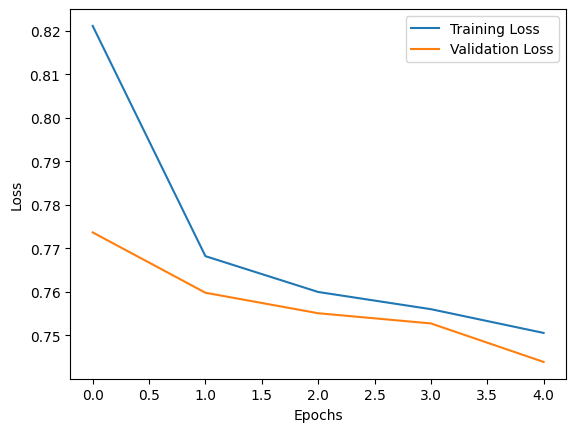

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Calculate reconstruction error on the normal test set
reconstructions = autoEncoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructions, 2), axis=1)

# Set a threshold as the 95th percentile of the reconstruction error
threshold = np.percentile(mse, 95)
print(f"Reconstruction error threshold: {threshold}")


2222/2222 [==============================] - 4s 2ms/step
Reconstruction error threshold: 1.6023210520013131


In [21]:
# Calculate reconstruction error on the full dataset
x_reconstructions = autoEncoder.predict(x)
mse_all = np.mean(np.power(x - x_reconstructions, 2), axis=1)

# Detect anomalies
y_pred = [1 if error > threshold else 0 for error in mse_all]




8901/8901 [==============================] - 14s 2ms/step


In [19]:
# Evaluate results
from sklearn.metrics import classification_report, confusion_matrix
# print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.88      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807



In [22]:
confusion_matrix(y, y_pred)

array([[270144,  14171],
       [    61,    431]], dtype=int64)